In [1]:
import pmdarima as pm

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

c:\Users\meghn\OneDrive\Desktop\Projects_2024\time-series-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### 1. Prepare dataset

In [3]:
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')

In [5]:
deaths_df.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260
265,NaN,Zimbabwe,-19.015438,29.154857,0,0,0,0,0,0,...,102,102,104,104,104,122,128,128,130,132


In [8]:
d = deaths_df.loc[:, '1/22/20':]
d.tail()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
261,0,0,0,0,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,0,0,0,0,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,0,0,0,0,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260
265,0,0,0,0,0,0,0,0,0,0,...,102,102,104,104,104,122,128,128,130,132


In [9]:
d = d.transpose()
d.tail()

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
8/12/20,1354,208,1333,53,80,3,5213,806,3,51,...,41329,37,211,247,18,105,1,528,246,122
8/13/20,1363,213,1341,53,80,3,5362,809,3,51,...,41347,37,216,259,21,106,1,528,246,128
8/14/20,1363,219,1351,53,86,3,5527,814,3,51,...,41358,38,220,266,22,106,1,528,256,128
8/15/20,1370,225,1360,53,86,3,5637,817,3,52,...,41361,38,225,276,24,108,1,528,260,130
8/16/20,1375,228,1370,53,88,3,5703,818,3,52,...,41366,38,232,281,24,110,1,530,260,132


In [10]:
d = d.sum(axis=1)
d.tail()

8/12/20    743989
8/13/20    750230
8/14/20    760374
8/15/20    765718
8/16/20    769904
dtype: int64

In [17]:
d = d.to_list()
len(d)

208

In [19]:
dataset = pd.DataFrame(columns =['ds', 'y'])

In [20]:
dates = list(deaths_df.columns[4:])
dates

['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/

In [21]:
dates = list(pd.to_datetime(dates))
dates[:5]

[Timestamp('2020-01-22 00:00:00'),
 Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-26 00:00:00')]

In [22]:
dataset['ds'] = dates
dataset['y']  = d 
dataset.tail()

,ds,y
203,2020-08-12,743989
204,2020-08-13,750230
205,2020-08-14,760374
206,2020-08-15,765718
207,2020-08-16,769904


In [23]:
dataset = dataset.set_index('ds')
dataset.tail()

,y
ds,
2020-08-12,743989
2020-08-13,750230
2020-08-14,760374
2020-08-15,765718
2020-08-16,769904


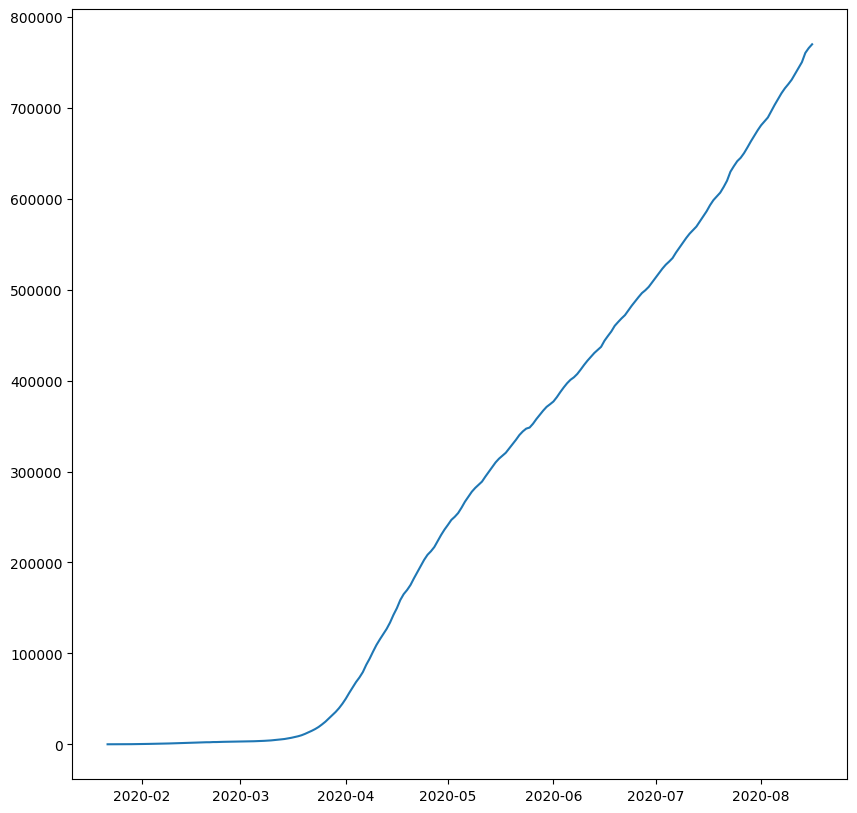

In [24]:
plt.figure(figsize=(10,10))
plt.plot(dataset)

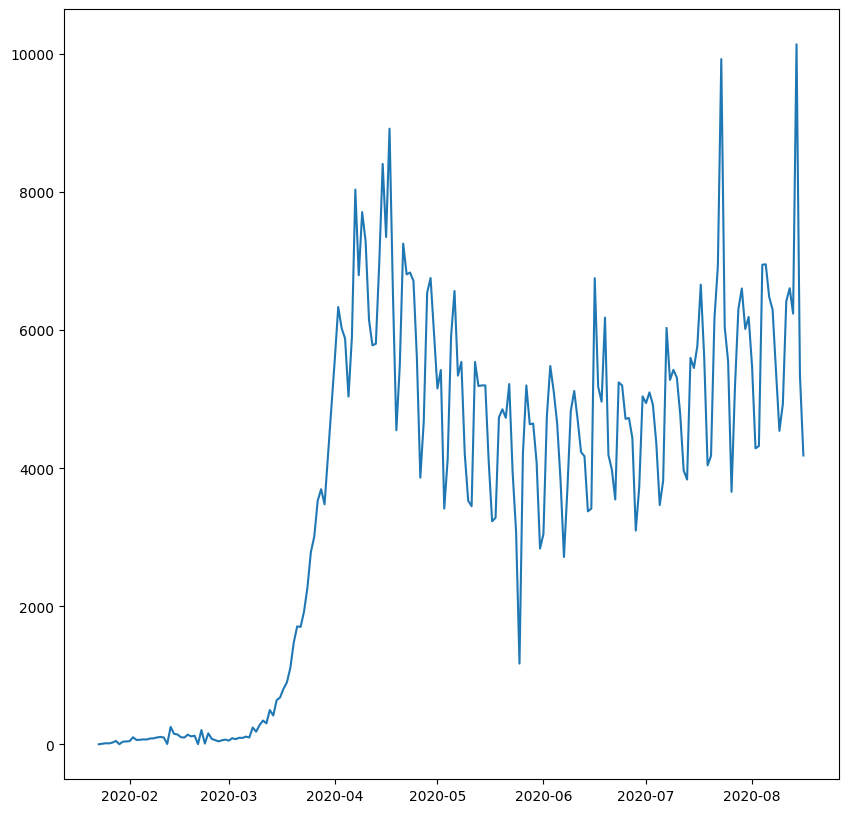

In [25]:
# Daily increase in deaths
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())

In [26]:
dataset = dataset.diff()
dataset.head()

,y
ds,
2020-01-22,NaN
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0


In [27]:
# Remove first null value
dataset = dataset.loc['2020-01-23':'2020-08-13']
dataset.head()

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0


### 2. Forecasting with SARIMAX

In [28]:
start_date = '2020-07-31'

train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

In [29]:
sarimax_model = SARIMAX(train, order=(2,1,3)).fit(disp=True)

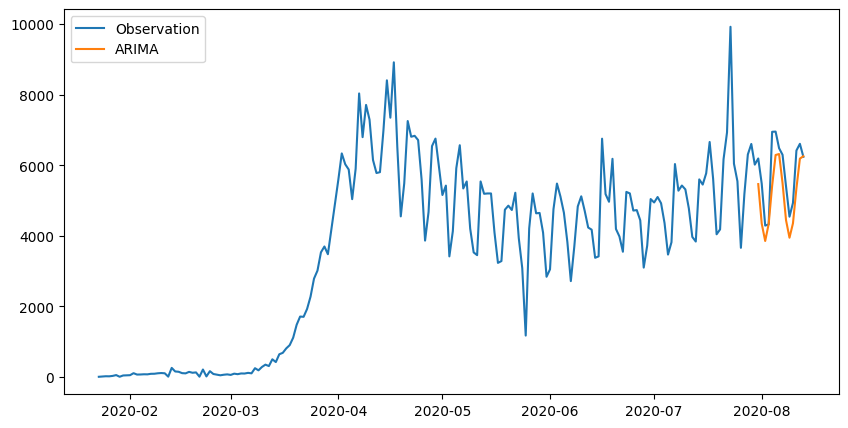

In [31]:
sarimax_predictions = sarimax_model.predict(start=start_date, end='2020-08-13', dynamic=False,)
plt.figure(figsize=(10,5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(sarimax_predictions, label='ARIMA')
plt.legend(handles=[l1,l2])

In [32]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_predictions, test))

SARIMAX MAE =  650.6131287478431


In [33]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.419, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.840, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.295, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.719, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

### 3. Forecasting using Prophet model

In [34]:
# Prophet model needs 2 columns
train['ds'] = train.index.values
train.head()

,y,ds
ds,,
2020-01-23,1.0,2020-01-23
2020-01-24,8.0,2020-01-24
2020-01-25,16.0,2020-01-25
2020-01-26,14.0,2020-01-26
2020-01-27,26.0,2020-01-27


In [35]:
prophet_model = Prophet().fit(train)
future = prophet_model.make_future_dataframe(periods=dataset.shape[0]-train.shape[0])
prophet_perdiction = prophet_model.predict(future)

12:20:07 - cmdstanpy - INFO - Chain [1] start processing
12:20:07 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
prophet_perdiction = prophet_perdiction.set_index('ds')
prophet_future = prophet_perdiction.yhat.loc[prophet_perdiction.index >= start_date]
print('Prophet model MAE = ', mean_absolute_error(prophet_future, test))

Prophet model MAE =  572.5525259953324


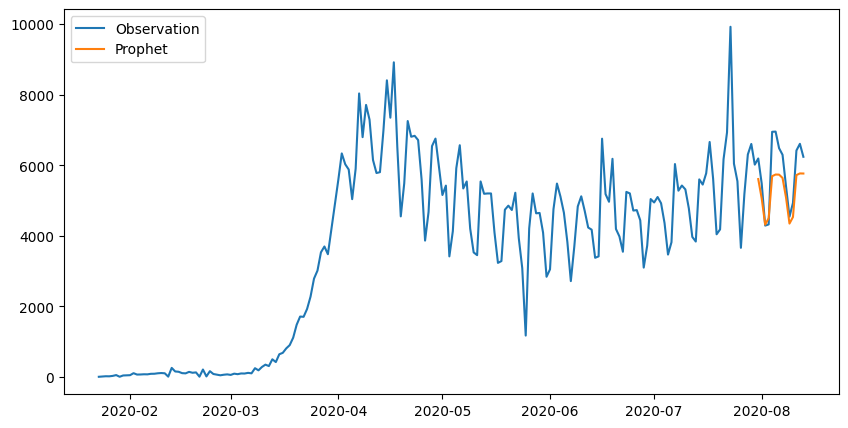

In [37]:
plt.figure(figsize=(10,5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])

### 3. Predictions using XGBoost and NN
#### 3.1 Data Preparation

In [67]:
# Extract features from a dataframe
def featurize(t):
    X = pd.DataFrame()

    X['day']   = t.index.day
    X['month'] = t.index.month
    X['weekOfYear'] = t.index.isocalendar().week.to_numpy(dtype="int64")
    X['quarter'] = t.index.quarter
    X['dayOfWeek'] = t.index.dayofweek
    X['dayOfYear'] = t.index.dayofyear
    X['dayOfWeek'] = t.index.dayofweek

    y = t.y
    return X, y

featurize(dataset)[0].head()

,day,month,weekOfYear,quarter,dayOfWeek,dayOfYear
0,23,1,4,1,3,23
1,24,1,4,1,4,24
2,25,1,4,1,5,25
3,26,1,4,1,6,26
4,27,1,5,1,0,27


In [69]:
# Splitting data
X_train, y_train = featurize(dataset.loc[dataset.index < pd.to_datetime(start_date)])
X_test, y_test   = featurize(dataset.loc[dataset.index >= pd.to_datetime(start_date)])

In [70]:
# Scaling values in the dataset
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 3.2 Training and prediction with XGBoost

In [71]:
# Training models
XGBoost_model = XGBRegressor(n_estimators=40)

XGBoost_model.fit(X=X_train_scaled, y=y_train,
                eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
                verbose=False)
XGBoost_prediction = XGBoost_model.predict(X_test_scaled)

In [ ]:
print('XGBoost MAE = ', mean_absolute_error(XGBoost_prediction, y_test))

XGBoost MAE =  206.12294224330358


#### 3.3 Training and prediction with NN

In [74]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(X_train_scaled.shape[1],)))
NN_model.add(Dense(20))
NN_model.add(Dense(1))

NN_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
NN_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled,y_test), epochs=220, verbose=True)
NN_prediction = NN_model.predict(X_test_scaled)

Epoch 1/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3673.1814 - val_loss: 5793.3638
Epoch 2/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3510.2092 - val_loss: 5793.3506
Epoch 3/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3666.5557 - val_loss: 5793.2266
Epoch 4/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3405.2507 - val_loss: 5793.2617
Epoch 5/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3447.6108 - val_loss: 5793.2578
Epoch 6/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3529.0864 - val_loss: 5793.1362
Epoch 7/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3331.1465 - val_loss: 5793.0757
Epoch 8/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3236.4207 - val_loss: 5793.0298
Epoch 9/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3557.6008 - val_loss: 5792.9263
Epoch 10/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3423.6597 - val_loss: 5792.8955
Epoch 11/220
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3503.9973 - val_loss: 5792.6289
Epoch 12

### 4. Comparison

In [75]:
print('SARIMA MAE = ', mean_absolute_error(sarimax_predictions, y_test))
print('Prophet MAE = ', mean_absolute_error(prophet_future, y_test))
print('XGBoost MAE = ', mean_absolute_error(XGBoost_prediction, y_test))
print('NN MAE = ', mean_absolute_error(NN_prediction, y_test))

SARIMA MAE =  650.6131287478431
Prophet MAE =  572.5525259953324
XGBoost MAE =  206.12294224330358
NN MAE =  889.1200474330357


<Figure size 2000x2000 with 0 Axes>

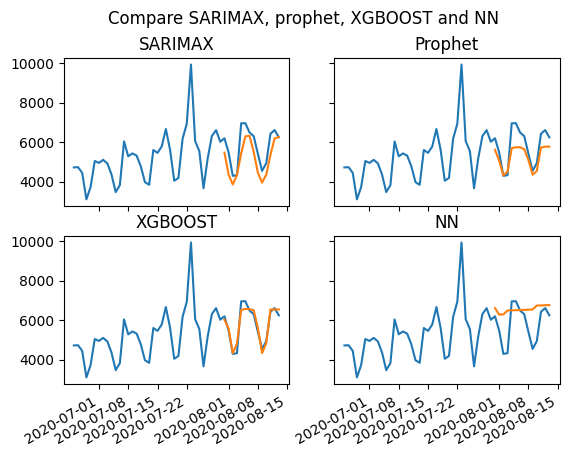

In [76]:
XGBOOST_df = pd.DataFrame({'y': XGBoost_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset.tail(50))
axs[0, 0].plot(sarimax_predictions.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)